# ImageCLEF2019 Medical Caption Task - Question Solutions

> Dimitrios Stefanou
> A.M. 3160245

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, layers, models, backend
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Data Exploration

In [3]:
string_c = pd.read_csv("string_concepts.csv", sep = '\t', header = None, names = ['tags', 'concepts'])
train_c = pd.read_csv("train_concepts.csv")
train_c['tags'] = train_c.tags.str.split(';')
val_c = pd.read_csv("val_concepts.csv")
val_c['tags'] = val_c.tags.str.split(';')

Number of tags

In [11]:
string_c

,tags,concepts
0,C0032143,r-tpa
1,C0225516,lower hypopharyngeal region
2,C0825429,bone surface
3,C0020461,excessive potassium in the blood
4,C0947912,proximal muscle weakness due to defect at the ...
...,...,...
5523,C0044955,prednylidene (pred)
5524,C3812869,medicated
5525,C2751430,camptodactyly and knuckle pads
5526,C0441621,sampled


Most frequent tags

In [12]:
temp = (train_c
 .set_index(['image'])['tags']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_1', axis = 1)
 .rename(columns={0 : 'tags'}))

In [6]:
frequency = temp.groupby('tags').count().reset_index().rename(columns = {"image" : "frequency"})
string_c.merge(frequency, how = 'left', on = 'tags').fillna(0).sort_values(by = 'frequency', ascending = False).head(10)

,tags,concepts,frequency
1928,C0441633,diagnostic scanning,6733.0
72,C0043299,x-ray procedure,6321.0
4340,C1962945,radiogr,6318.0
2754,C0040395,tomogr,6235.0
3647,C0034579,pantomogr,6127.0
1235,C0817096,thoracics,5981.0
1484,C0040405,x-ray computer assisted tomography,5801.0
2602,C1548003,radiograph,5159.0
1211,C0221198,visible lesion,4513.0
4946,C0772294,alesion,4512.0


Number of tags per image

In [7]:
perimage = temp.groupby('image').count().reset_index().rename(columns = {"tags" : "number of tags"}).sort_values(by = ['number of tags'], ascending = False)
perimage

,image,number of tags
55486,ROCO_CLEF_69357,72
37295,ROCO_CLEF_46672,70
35775,ROCO_CLEF_44813,69
2863,ROCO_CLEF_03622,64
12180,ROCO_CLEF_15228,56
...,...,...
3653,ROCO_CLEF_04605,1
37866,ROCO_CLEF_47387,1
37874,ROCO_CLEF_47398,1
37881,ROCO_CLEF_47406,1


Image plotting

In [8]:
def get_concepts(img_name):
    tags = train_c[train_c.image == img_name].tags.iloc[0]
    concepts = []
    for i in tags:
        concepts.append([string_c[string_c.tags == i].concepts.iloc[0]])
    return concepts

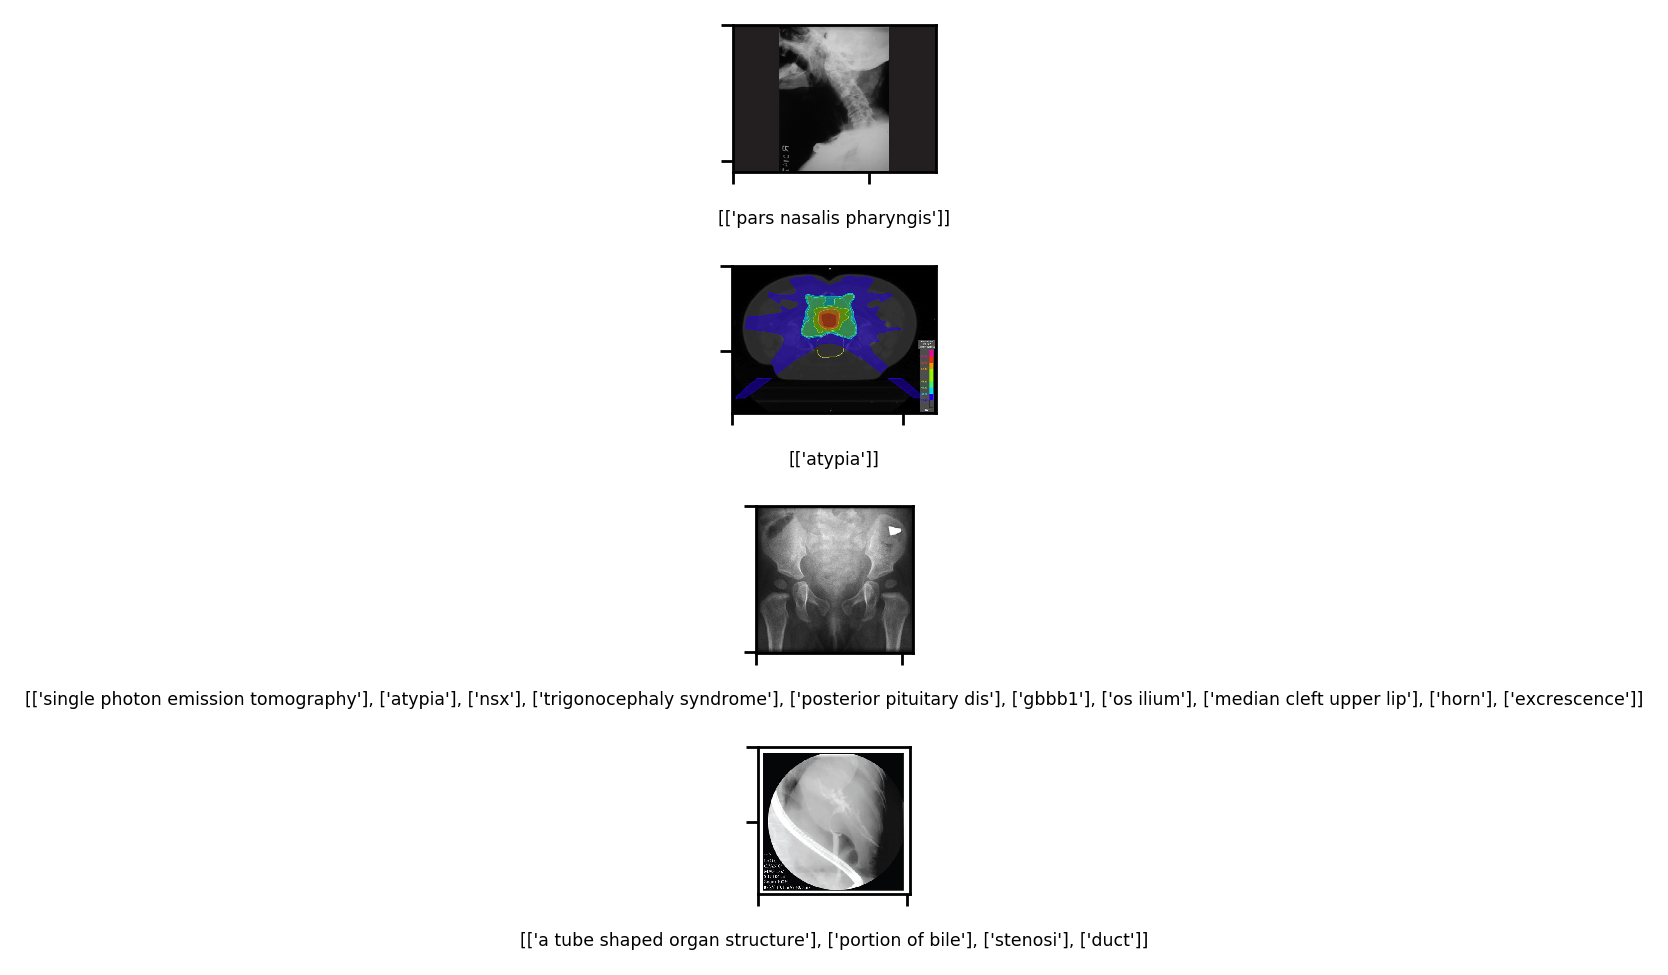

In [9]:
fig, ax = plt.subplots(4,1)
ax[0].imshow(mpimg.imread('training-set/ROCO_CLEF_00000.jpg'))
ax[0].set_xlabel(get_concepts('ROCO_CLEF_00000'), fontsize = 5)
ax[0].set_xticklabels(())
ax[0].set_yticklabels(())

ax[1].imshow(mpimg.imread('training-set/ROCO_CLEF_00001.jpg'))
ax[1].set_xlabel(get_concepts('ROCO_CLEF_00001'), fontsize = 5)
ax[1].set_xticklabels(())
ax[1].set_yticklabels(())

ax[2].imshow(mpimg.imread('training-set/ROCO_CLEF_00003.jpg'))
ax[2].set_xlabel(get_concepts('ROCO_CLEF_00003'), fontsize = 5)
ax[2].set_xticklabels(())
ax[2].set_yticklabels(())

ax[3].imshow(mpimg.imread('training-set/ROCO_CLEF_00004.jpg'))
ax[3].set_xlabel(get_concepts('ROCO_CLEF_00004'), fontsize = 5)
ax[3].set_xticklabels(())
ax[3].set_yticklabels(())
fig.dpi = 250
fig.tight_layout()
plt.show()

### Data Preprocessing

In [4]:
train_c['image'] = train_c.image.astype(str) + '.jpg'
val_c['image'] = val_c.image.astype(str) + '.jpg'

testdf = pd.DataFrame()
testdf['image'] = os.listdir('test-set')

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)
hw = 224
batch=32

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_c,
    directory="./training-set",
    x_col="image",
    y_col="tags",
    batch_size=batch,
    class_mode="categorical",
    classes=string_c.tags.to_list(),
    target_size=(hw, hw),
    shuffle=False
)

valid_generator=valid_datagen.flow_from_dataframe(
    dataframe=val_c,
    directory="./validation-set",
    x_col="image",
    y_col="tags",
    batch_size=batch,
    class_mode="categorical",
    classes=string_c.tags.to_list(),
    target_size=(hw, hw),
    shuffle=False
)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="./test-set",
    x_col="image",
    batch_size=1,
    class_mode=None,
    target_size=(hw, hw),
    shuffle=False
)

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.
Found 10000 validated image filenames.


* f1 is used for the baseline, f1_metric is used on neural networks

In [6]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    # precision and recall
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Dummy Classifier for baseline
Does not predict multiple labels, but a single class for a batch of our train_generator

In [7]:
dum_gen = train_generator
X, y_true = next(dum_gen)
dummy = DummyClassifier()
dummy.fit(X, y_true)
y_pred = dummy.predict(X)
f1(y_true, y_pred).numpy()

0.0010626552

### CNN

In [8]:
model = Sequential([
        
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(hw, hw, 3)),
    AveragePooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),  
    Conv2D(512, 3, padding='same', activation='relu'),
    AveragePooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),   
    Conv2D(256, 3, padding='same', activation='relu'),
    AveragePooling2D(),      
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    
    Flatten(),
    Dense(5528, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 512)       590336    
_________________________________________________________________
average_pooling2d_1 (Average (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       1

In [9]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=64,#len(train_c.index) // batch,
    epochs=3, 
    validation_data=valid_generator, 
    validation_steps=32,#len(val_c) // batch,
    callbacks=[tfdocs.modeling.EpochDots()]
)

Epoch 1/3
63/64 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.9818 - f1_metric: 0.0999
Epoch: 0, accuracy:0.9821,  f1_metric:0.0994,  loss:0.0704,  val_accuracy:0.9972,  val_f1_metric:0.1081,  val_loss:0.0426,  
64/64 [==============================] - 21s 334ms/step - loss: 0.0704 - accuracy: 0.9821 - f1_metric: 0.0994 - val_loss: 0.0426 - val_accuracy: 0.9972 - val_f1_metric: 0.1081
Epoch 2/3
64/64 [==============================] - 18s 277ms/step - loss: 0.0424 - accuracy: 0.9972 - f1_metric: 0.1038 - val_loss: 0.0426 - val_accuracy: 0.9972 - val_f1_metric: 0.1081
Epoch 3/3
64/64 [==============================] - 18s 283ms/step - loss: 0.0427 - accuracy: 0.9972 - f1_metric: 0.1053 - val_loss: 0.0425 - val_accuracy: 0.9972 - val_f1_metric: 0.1083


Text(0.5, 1.0, 'Training and Validation Loss')

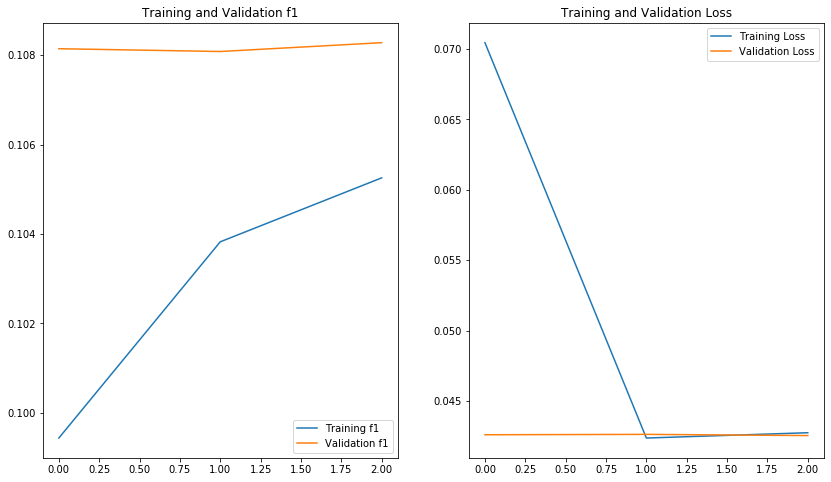

In [11]:
f1 = history.history['f1_metric']
val_f1 = history.history['val_f1_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, f1, label='Training f1')
plt.plot(epochs_range, val_f1, label='Validation f1')
plt.legend(loc='lower right')
plt.title('Training and Validation f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [12]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=10000, verbose=1)

10000/10000 [==============================] - 59s 6ms/step


In [13]:
pred = pd.DataFrame(predictions, columns = string_c.tags.to_list())

subdf = pd.DataFrame(columns = {'image', 'tags'})
subdf['image'] = os.listdir('test-set')
subdf['image'] = subdf['image'].str[:-4]

tags = []
for index, row in pred.iterrows():
    row = [row.sort_values(ascending=False).to_frame().head(100).index.tolist()]
    tags.append(row)

flat_list = []
for sublist in tags:
    for item in sublist:
        flat_list.append(item)

i = 0
for sublist in flat_list:
    subdf['tags'].loc[i] = ';'.join(sublist)
    i = i + 1
print('Done!')

Done!


### Submission

In [14]:
columnsTitles = ['image', 'tags']
subdf = subdf.reindex(columns=columnsTitles)
subdf.to_csv('submission.csv', sep='\t', index=False, header=False)

## Final words

* Due to the increased workload towards the end of the semester and health reasons, this project was unfortunately rushed. 
* Failed attempts include the use of DenseNet121, which due to time constraints could not be optimized
* The steps on fit_generator were placed low on purpose; predict_generator sometimes crashed due to low memory with the 'correct' ones
* The final predictions seem to be predicted in a wrong manner; instead of probabilities, the CNN returned integers (0, 1). I did not have time ti investigate why the multilabel part of the classification failed, even though I had set the correct activation layer and loss metric.